In [135]:
import pandas as pd
import numpy as np
# Importing airquality module
from airquality import AirQuality
import plotly.express as px
from matplotlib import pyplot

# For investigating timeseries data
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Global Variables
REFRESH_DATA = False
DATA_QUANTITY = 336

In [136]:
# Defining city id's
city1_ids = [ 1067, 1068, 1069, 1502]

In [137]:
combined_df = []
if REFRESH_DATA:
    air_measurements = []
    # Iterating through sensor locations and creating object to store data for each
    for location in city1_ids:
        quality = AirQuality(location)
        quality.pull_data(200)
        air_measurements.append(quality.raw_data)

    combined_df = pd.concat(air_measurements)
    combined_df.to_csv('./Data/air_polution.csv')
    combined_df.head(10)
else:
    combined_df = pd.read_csv('./Data/air_polution.csv')

In [138]:
combined_df['location'] = combined_df['location'].astype(str)

### Timeseries

In [139]:
timeseries_plot = px.line(combined_df, x = 'Data_Converted', y = 'Value', color='location',
                                title = "pm25 polution, Portland Oregon")
timeseries_plot.show()

### Developing Forecast

In [140]:
print(combined_df['location'].drop_duplicates())
test_df = combined_df[combined_df['location'] == '1067']
test_df.head(10)

0      1067
188    1068
376    1069
564    1502
Name: location, dtype: object


,Unnamed: 0,Date,Value,location,parameter,Data_Converted
0,0,2024-06-06T20:00:00+00:00,4.6,1067,pm25,2024-06-06 20:00:00+00:00
1,1,2024-06-06T19:00:00+00:00,4.9,1067,pm25,2024-06-06 19:00:00+00:00
2,2,2024-06-06T18:00:00+00:00,4.9,1067,pm25,2024-06-06 18:00:00+00:00
3,3,2024-06-06T17:00:00+00:00,4.8,1067,pm25,2024-06-06 17:00:00+00:00
4,4,2024-06-06T16:00:00+00:00,5.0,1067,pm25,2024-06-06 16:00:00+00:00
5,5,2024-06-06T15:00:00+00:00,4.9,1067,pm25,2024-06-06 15:00:00+00:00
6,6,2024-06-06T14:00:00+00:00,4.8,1067,pm25,2024-06-06 14:00:00+00:00
7,7,2024-06-06T13:00:00+00:00,4.8,1067,pm25,2024-06-06 13:00:00+00:00
8,8,2024-06-06T12:00:00+00:00,4.9,1067,pm25,2024-06-06 12:00:00+00:00
9,9,2024-06-06T11:00:00+00:00,5.0,1067,pm25,2024-06-06 11:00:00+00:00


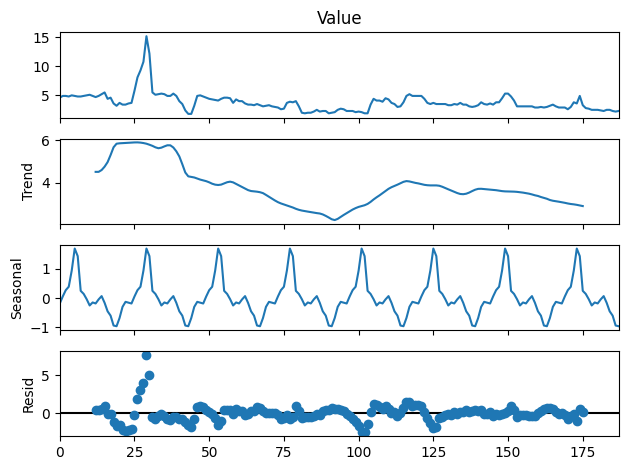

In [141]:
result = seasonal_decompose(combined_df[combined_df['location'] == '1067']['Value'], 
                            model='additive', period=24)
result.plot()
pyplot.show()

### Univariate Timeseries Analysis

Ad Fuller Test:

H0: There's a root unit present in the timeseries(i.e. not stationary)

H1: There's no root unit present in the timeseries(i.e. data is stationary)

If P < critical value(0.05) conclude that H0 is false and data is stationary.


In [142]:
target_location = combined_df['location'].drop_duplicates()[0]
univariate_df = combined_df[combined_df['location'] == target_location]

# Checking if data is stationary
adf_results = adfuller(univariate_df['Value'])

print("Statistic: ", round(adf_results[0],3))
print("P-value: ", round(adf_results[1],6))

Statistic:  -3.646
P-value:  0.004947


### Plotting ACF and PACF
1. Moving Average portion of model(q) depends on ACF test
2. Autoregressive portion of model(p) depends on PACF test


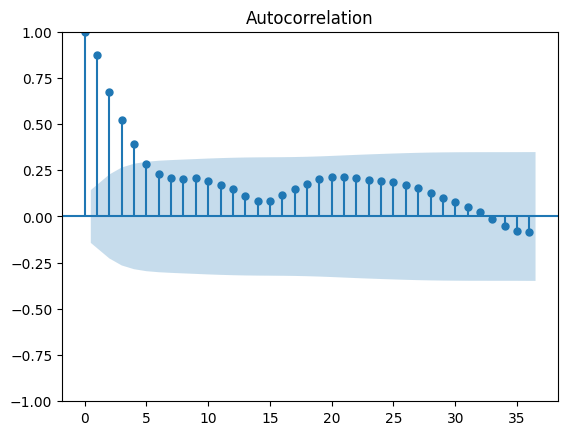

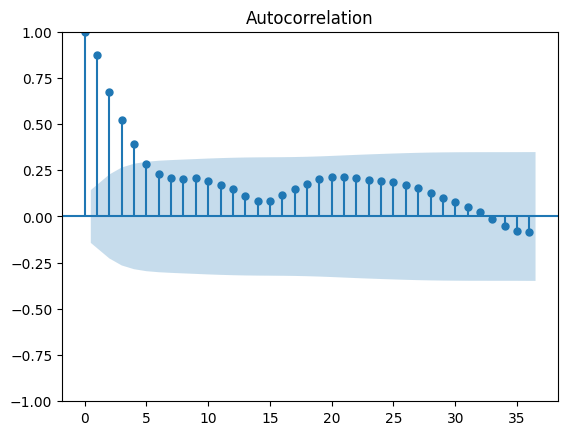

In [143]:
plot_acf(univariate_df['Value'], lags=36)

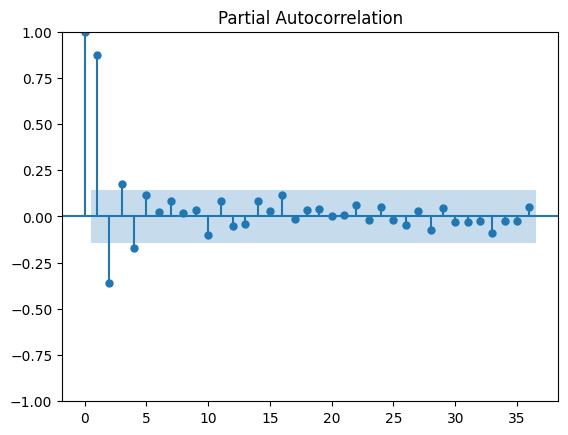

In [144]:
plot_pacf(univariate_df['Value'], lags=36)
pyplot.show()

### Building ARIMA Model

Order is defined as (p,d,q) = (Autoregressive, integration(how many times we difference), Moving Average)

In [145]:
order = (5, 0, 2)
model = ARIMA(univariate_df['Value'], order= order)

In [146]:
univariate_df = univariate_df.sort_values(by = 'Data_Converted')

In [147]:
# split into train and test sets
X = univariate_df['Value'].values
# Train - non 2021 months, Test - 2021 months
size = int(len(X) - 24) 
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = []

In [148]:
predictions = []
for month in range(len(test)):
    fitting_df = univariate_df['Value'][:len(train)+month]
    model = ARIMA(fitting_df, order= order)
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = list(output)[0]
    predictions.append(yhat)


c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Air Polution Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.


In [149]:
# evaluate forecasts
r2 = r2_score(univariate_df['Value'][-len(predictions):], predictions)
print('Test R2 Score: %.3f' % r2)

Test R2 Score: 0.372


In [150]:
# Melting down comparison dataframe for plotting
actual_df = univariate_df[['Data_Converted', 'Value']]
actual_df['Variable'] = 'Actual'
dates = univariate_df['Data_Converted'][-len(predictions):]
test_dict = {'Data_Converted': dates,
                             'Value': predictions}

predicted_df = pd.DataFrame.from_dict(test_dict)
predicted_df['Variable'] = 'Predicted'
compare_df = pd.concat([actual_df, predicted_df])

C:\Users\seelc\AppData\Local\Temp\ipykernel_2088\3599212786.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [151]:
# Graphing predictions vs actual values
predictions_fig = px.line(compare_df,x = 'Data_Converted', y = 'Value', color = 'Variable', 
                            title = 'Air Polution Forecasted vs Acual ' + 'R2 Score: '+ str(round(r2,2)))
predictions_fig.show()

### Multivariate Model

First we want to measure the correlation of exogenous variables at offset value t with our response variable. To do this we'll create a helper function to offset our data and measure correlation using a pearson correlation coefficient.

In [179]:
def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 

    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))

Next we need to reshape our data so each of the values of the locations is a separate column.

In [180]:
test_df = combined_df.sort_values(by = 'Data_Converted')
locations = combined_df['location'].drop_duplicates().to_list()
temp_key_storage = {}
temp_key_storage['Date'] = combined_df['Data_Converted'].drop_duplicates().to_list()
for location in locations:
    temp_key_storage[location] = combined_df[combined_df['location'] == location]['Value'].to_list()

multivariate_df = pd.DataFrame.from_dict(temp_key_storage)
multivariate_df.head(10)

<class 'pandas.core.frame.DataFrame'>


In [186]:
# Creating list of x_vars and dropping date
x_vars = multivariate_df.columns.to_list()[1:]
# Saving response variable
response_var = multivariate_df.columns.to_list()[1]
# Dropping response variable form x_vars
corr_matrix = []
x_vars = x_vars[1:]
lags = range(1,6)
for var in x_vars:
    var_cor = []
    for lag in lags:
        var_cor.append(round(crosscorr(multivariate_df[response_var], multivariate_df[var], lag = lag),2))
    corr_matrix.append(var_cor)

range(1, 6)
1068
1
2
3
4
5
1069
1
2
3
4
5
1502
1
2
3
4
5


In [187]:
print(lags)
fig = px.imshow(corr_matrix,
                labels=dict(x="Lag", y="Variable", color="Pearson Correlation"),
                x=[i for i in lags],
                y=x_vars,
                text_auto=True,
                title= "Variable Correlation Exogenous variables"
               )
fig.show()

range(1, 6)
